
# Leaf Classification using Machine Learning

#### W.Tao

----
***Abstract:*** A leaf is like the "fingerprint" of a plant, which can be used to classify its species. This project is to identify 99 species of plants based on three sets of features of their leaves, i.e. shape, margin and texture. Machine learning methods including Naive Bayes, Support Vector Machine (SVM), Logistic Regression, k-nearest neighbours (k-NN) and Linear Discriminant Analysis are implemented and compared. Standard-scaler is applied to preprocess the data. Cross-validation is used to improve the generalization performance of the model. Grid-search is used in finding the optimal parameters. The best prediction accurary is from Logistic Regression, which has the accuracy of ~99%.


## 1. Introduction:
This project is inspired by a [Kaggle playground competition](https://www.kaggle.com/c/leaf-classification). 

> **Background**: There are estimated to be nearly half a million species of plant in the world. Classification of species has been historically problematic and often results in duplicate identifications. Automating plant recognition might have many applications, including:

> - Species population tracking and preservation
> - Plant-based medicinal research
> - Crop and food supply management

The **objective** is to use binary leaf images to identify 99 species of plants via Machine Learning (ML) methods. Three sets of pre-extracted features are provided, including shape, margin and texture.

Then this task becomes a typical ***multiclass classification*** problem.
- classification
    - <del>binary</del>
    - ***multiclass***
- <del>regression</del>


## 2. Datasets:
The dataset consists approximately 1,584 images of leaf specimens (16 samples each of 99 species in total, 10 samples each of 99 species are labeled, the other 6 samples are used to evaluate the model via Kaggle) which have been converted to binary black leaves against white backgrounds. Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.

**Let's have a look at the given datasets:**

In [1]:
# Importing some useful/necessary packages
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, log_loss

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import cv2

%matplotlib inline

In [2]:
# Read the .csv files as pandas dataframe
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

#print type(train_raw), type(test_raw)
print 'There are {}'.format(train_raw.shape[0]), \
       'samples for building the machine learning model and {}'.format(test_raw.shape[0]), \
       'samples for evaluating your model via Kaggle.'

There are 990 samples for building the machine learning model and 594 samples for evaluating your model via Kaggle.


In [3]:
# Let's look at the first 5 rows of train_raw dataset
train_raw.head(5)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


**train_raw** dataset has the shape of [990x194]. 990 represents the number of species, and 194 represents individual features in columns i.e. 'id', 'species', 'margin1~64', 'shape1~64', 'texture1~64'.

More in detail for 194:
- id - an anonymous id unique to an image
- species - 99 species, not given in test.csv
- margin_1, margin_2, margin_3, ..., margin_64 - each of the 64 attribute vectors for the margin feature
- shape_1, shape_2, shape_3, ..., shape_64 - each of the 64 attribute vectors for the shape feature
- texture_1, texture_2, texture_3, ..., texture_64 - each of the 64 attribute vectors for the texture feature

## 3. Methods

To make life easier, *Python* and *Scikit-learn* were depolyed in this project.

> Scikit-learn provides us all kinds of powerful tools to solve this classification problem. What we need to do is pick a proper model and use the optimal parameters to maximize the performance of this classifier.

#### Cross-validation
> *Cross-Validation* is a statistical method of evaluating generalization performance that is more stable and thorough than using a test set. In cross-validation, the data is instead split repeatedly and multiple models are trained. [Ref.Müller]

> The most commonly used cross-validation methods are:
> - k-fold cross-validation
> - leave-one-out 

#### Grid Search
> Grid search is the most commonly used method to find the values of the important parameters of a model. It basically means trying all possible combinitions of the parameters of interest. [Ref. Müller]

**Scikit-learn** provides the **GridSearchCV** class to implement grid-search with cross-validation, which is a commonly used method to find the optimal parameters. The overview of Grid-search is shown below.

 <p></p>
<figure>
 <img src="images_/gridsearch.png" width="400" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Figure 1. Overview of the process of parameter selection and model evaluation with GridSearchCVGrid Search Overview [Ref. Müller] </p> 
 </figcaption>
</figure> 

The pipeline of the machine learning process for this project is listed as follows:

**Algorithm Chain and Pipeline**:
1. Preprocess the data
    - Split for cross-validation
    - Standard-scaler (optional)
- Feed the preprocessed data into the selected classifiers
    1. Naive Bayes
    - Support Vector Machine (SVM)
    - Logistic Regression
    - k-nearest neighbours (k-NN)
    - Linear Discriminant Analysis 
- Evaluate the classifiers

**Evaluation Metrics**

Submissions for Kaggle are evaluated using the multi-class logarithmic loss. Each image has been labeled with one true species. For each image, Kaggle requires to submit a set of predicted probabilities (one for every species). The equation of logarithmic loss is then,

\begin{equation*}
logloss= -\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^M y_{ij} log(p_{ij})
\end{equation*}


where $N$ is the number of images in the test set, $M$ is the number of species labels, $log$ is the natural logarithm, $y_{ij}$ is 1 if observation \\(i\\) is in class \\(j\\) and 0 otherwise, and \\(p_{ij}\\) is the predicted probability that observation \\(i\\) belongs to class \\(j\\).

The submitted probabilities for a given device are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum), but they need to be in the range of [0, 1]. In order to avoid the extremes of the log function, predicted probabilities are replaced with $max(min(p,1-10^{-15}),10^{-15})$.


## 4. Implementation

### 4.1 Data preprocessing for classifiers

To organize the data, scikit learn provides [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [4]:
# Preprocess the data to fit for the classifier
le = LabelEncoder().fit(train_raw.species) # Instantiate a LabelEncoder and fit to the given label data
labels = le.transform(train_raw.species)  # encode species strings and return labels with value between 0 and n_classes-1
classes = list(le.classes_)  # Save the species
test_ids = test_raw.id  # Save the image ids in test dataset

train = train_raw.drop(['id', 'species'], axis=1)
test = test_raw.drop(['id'], axis=1)

In [5]:
# Double check the data
print "The shapes of train and labels are: ", train.shape, labels.shape
print "There are {} species in total.".format(len(classes)) 
print "The shapes of test and test_ids are: ", test.shape, test_ids.shape

The shapes of train and labels are:  (990, 192) (990L,)
There are 99 species in total.
The shapes of test and test_ids are:  (594, 192) (594L,)


#### Split the 'train' data for cross-validation
[StratifiedShuffleSplit](http://lijiancheng0614.github.io/scikit-learn/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html) cross validation iterator is used to split the training dataset.

In [6]:
# construct the iterator
ss_split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
ss_split.get_n_splits(train, labels)

for train_index, test_index in ss_split.split(train, labels):   
    X_train, X_test = train.values[train_index], train.values[test_index]
    y_train, y_test = labels[train_index], labels[test_index]   

Now we have split the 'train' dataset into two parts:
- X_train, y_train
- X_test, y_test

In [7]:
# Double check the data
print y_train.shape, y_test.shape

(792L,) (198L,)


**Let's define some useful functions to visualize the images**

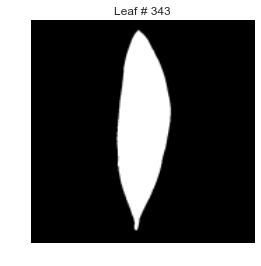

In [8]:
def leaf_image(image_id,target_length=160):
    """
    `image_id` should be the index of the image in the images/ folder
        
    Reture the image of a given id(1~1584) with the target size (target_length x target_length)
    
    """
    
    image_name = str(image_id) + '.jpg'
    leaf_img = plt.imread('images/'+image_name)  # Reading in the image 
    leaf_img_width = leaf_img.shape[1]
    leaf_img_height = leaf_img.shape[0]
    #target_length = 160
    img_target = np.zeros((target_length, target_length), np.uint8)
    if leaf_img_width >= leaf_img_height:
        scale_img_width = target_length
        scale_img_height = int( (float(scale_img_width)/leaf_img_width)*leaf_img_height )
        img_scaled = cv2.resize(leaf_img, (scale_img_width, scale_img_height), interpolation = cv2.INTER_AREA)
        copy_location = (target_length-scale_img_height)/2
        img_target[copy_location:copy_location+scale_img_height,:] = img_scaled
    else:
        # leaf_img_width < leaf_img_height:
        scale_img_height = target_length
        scale_img_width = int( (float(scale_img_height)/leaf_img_height)*leaf_img_width )
        img_scaled = cv2.resize(leaf_img, (scale_img_width, scale_img_height), interpolation = cv2.INTER_AREA)
        copy_location = (target_length-scale_img_width)/2
        img_target[:, copy_location:copy_location+scale_img_width] = img_scaled 
    
    return img_target


# Test the leaf_image function
leaf_id = 343
leaf_img = leaf_image(leaf_id, target_length=160); 

plt.imshow(leaf_img, cmap='gray'); plt.title('Leaf # '+str(leaf_id)); plt.axis('off'); plt.show()

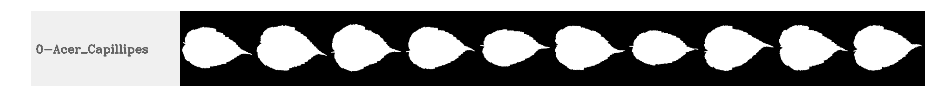

0-Acer_Capillipes


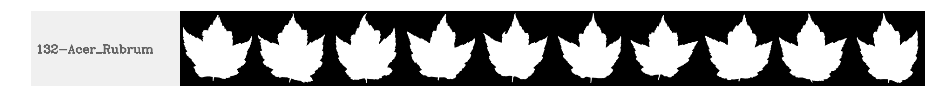

In [9]:
def species_image(species):
    """
    `species` should be the index or species name
        
    Returns an image of a certain labeled species
    """
    
    leaf_image_length = 160
    #img_target = np.zeros([leaf_image_length, 0], np.uint8)  # Initialization
    img_target = 240*np.ones([leaf_image_length, leaf_image_length*2], np.uint8)  # Initialization
    label_info = ''
    #if type(species)==int and species >= 0 and species < 99:
    if species >= 0 and species < 99:
        images_index = np.where(labels==species)[0]
        label_info = str(species) + '-' + train_raw.species[images_index[0]]
    elif type(species)==str and species in classes:
        images_index = np.where(train_raw.species==species)[0]
        label_info = str(images_index[0]) + '-' + species
    else:
        print 'Error: Please input a valid index or species name'
        return
    for image_index in images_index:
        image_id = train_raw.id[image_index]
        leaf_img = leaf_image(image_id)
        img_target = np.append(img_target, leaf_img, axis=1)
    
    # Add information onto the first block
    cv2.putText(img_target, label_info, (10,90), cv2.FONT_HERSHEY_COMPLEX, 0.8, (100,170,0), 2)
            
    return img_target, label_info
        
    
    
# Test the function
species_img, label_info = species_image(0)  # Show this species of given index(0~98)
fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w',frameon=False,linewidth = 0)
plt.imshow(species_img, cmap='gray'); plt.axis('off'); plt.show()
print label_info
#cv2.imwrite('species/'+label_info+'.jpg', species_img)  # Save the species image


species_img, label_info = species_image('Acer_Rubrum')  # show the species of give name
fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w',frameon=False,linewidth = 0)
plt.imshow(species_img, cmap='gray'); plt.axis('off'); plt.show()

In [10]:
def visualize_error(train_predictions, y_test):
    """
    Review the images where mistakes occur
        
    """
    
    error_indices = np.where(train_predictions != y_test)[0]; print 'The error indices: ', error_indices
    for err_index in error_indices[0:]: 
        print 'Error index in the test set: ', err_index

        err_img_index = train_raw.id[test_index[err_index]]

        print 'Ground truth species index: {}'.format(y_test[err_index])
        print 'Wrong predicting species index: {}'.format(train_predictions[err_index])


        plt.imshow(leaf_image(err_img_index, 160), cmap='gray'); plt.axis('off'); plt.show()

        wrong_pred_species_img, label_info = species_image(train_predictions[err_index])
        fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w',frameon=False,linewidth = 0)
        wrong_pred_species_img = cv2.cvtColor(wrong_pred_species_img,cv2.COLOR_GRAY2RGB)
        wrong_pred_species_img = cv2.copyMakeBorder(wrong_pred_species_img,10,10,10,10,cv2.BORDER_CONSTANT,value=[255,0,0])

        plt.imshow(wrong_pred_species_img, cmap='gray'); plt.axis('off'); plt.show()

        ground_truth_species_img, label_info = species_image(y_test[err_index])
        fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w',frameon=False,linewidth = 0)
        plt.imshow(ground_truth_species_img, cmap='gray'); plt.axis('off'); plt.show()

        print '#'*50

In [ ]:
# List and save all the classes
for i, class_ in enumerate(classes):
    species_img, label_info = species_image(i)  # Show this species of given index(0~98)
    print label_info
    cv2.imwrite('species/'+label_info+'.jpg', species_img)

### 4.2 Machine learning classifiers

The following listed classifiers are selected in this project as their popularity.
1. Naive Bayes
- SVM
- Logistic Regression
- k-nearest neighbours (k-NN)
- LinearDiscriminantAnalysis


#### 4.2.1 Naive Bayes

In [39]:
clf = GaussianNB().fit(X_train, y_train) # Instantiate a classifier and fit this classifier to the data
print 'ML Model: ', clf.__class__.__name__

# Cross-validation
scores = cross_val_score(GaussianNB(), train.values, labels, cv=ss_split)
#print 'Mean Cross-validation scores: {}'.format(np.mean(scores))

train_predictions = clf.predict(X_test)
acc = accuracy_score(y_test, train_predictions)
print 'Accuracy: {:.4%}'.format(acc)

train_predictions = clf.predict_proba(X_test)
ll = log_loss(y_test, train_predictions)
print 'Log Loss: {:.6}'.format(ll)

ML Model:  GaussianNB
Accuracy: 55.0505%
Log Loss: 15.5066


#### 4.2.2 Support Vector Machine

In [11]:
clf = SVC(probability=True)

# Gird search
#param_grid = {'C': [1, 10, 100, 1000, 10000, 100000],
#              'gamma': [1, 10, 100, 1000, 10000, 100000]}
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(SVC(probability=True), param_grid=param_grid, cv=ss_split)
grid_search.fit(X_train, y_train)

print 'Best parameter: {}'.format(grid_search.best_params_)
print 'Best cross-validation accuracy score: {}'.format(grid_search.best_score_)
print '\nBest estimator:\n{}'.format(grid_search.best_estimator_)

Best parameter: {'C': 100, 'gamma': 1}
Best cross-validation accuracy score: 0.927672955975

Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


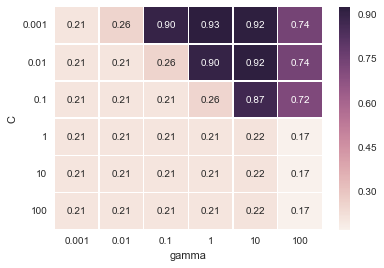

ML Model:  SVC
Accuracy: 93.4343%
Log Loss: 2.30322


In [12]:
# Convert to DataFrame
results = pd.DataFrame(grid_search.cv_results_)
# Show the first 5 rows of the result
#print results.head()

scores = np.array(results.mean_test_score).reshape(6, 6)

ax = sns.heatmap(scores, annot=True, fmt=".2f",linewidths=.5);
ax.invert_yaxis()
ax.set(xticklabels=param_grid['gamma']); ax.set(yticklabels=param_grid['C'])
plt.yticks(rotation=0) 
plt.xlabel('gamma'); plt.ylabel('C'); plt.show()

print 'ML Model: ', clf.__class__.__name__
# Accuracy
train_predictions = grid_search.predict(X_test)
acc = accuracy_score(y_test, train_predictions)
print 'Accuracy: {:.4%}'.format(acc)
# Logloss
train_predictions = grid_search.predict_proba(X_test)
ll = log_loss(y_test, train_predictions)
print 'Log Loss: {:.6}'.format(ll)

To further specify the optimal parameters, another round of grid-search was implemented. The result is shown in the following figure. Then we can see that the best parameters are still {'C': 100, 'gamma': 1}.
<figure>
 
 <img src="images_/svm02.png" width="400" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Figure 2. Overview  </p> 
 </figcaption>
</figure>


#### 4.2.3 Logistic Regression

In [26]:
# Standardize the training data.
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

#param_grid = {'C':[1, 10], 
#              'tol': [0.001, 0.0001]}
param_grid = {'C': [ 1000, 10000],
              'tol': [0.000001, 0.00001]}
log_reg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
grid_search = GridSearchCV(log_reg, param_grid, scoring='neg_log_loss', refit='True', n_jobs=1, cv=ss_split)
grid_search.fit(X_train_scaled, y_train)

print 'Best parameter: {}'.format(grid_search.best_params_)
print 'Best cross-validation neg_log_loss score: {}'.format(grid_search.best_score_)
print '\nBest estimator:\n{}'.format(grid_search.best_estimator_)

Best parameter: {'C': 1000, 'tol': 1e-06}
Best cross-validation neg_log_loss score: -0.0596465344203

Best estimator:
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=1e-06, verbose=0, warm_start=False)


In [27]:
scaler = StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)

print 'ML Model: Logistic Regression'
# Accuracy
train_predictions = grid_search.predict(X_test_scaled)
acc = accuracy_score(y_test, train_predictions)
print 'Accuracy: {:.4%}'.format(acc)
# Logloss
train_predictions_p = grid_search.predict_proba(X_test_scaled)
ll = log_loss(y_test, train_predictions_p)
print 'Log Loss: {:.6}'.format(ll)

ML Model: Logistic Regression
Accuracy: 98.9899%
Log Loss: 0.0253899


The error indices:  [ 24 125]
Error index in the test set:  24
Ground truth species index: 48
Wrong predicting species index: 41


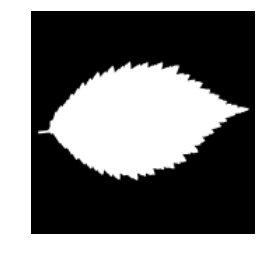

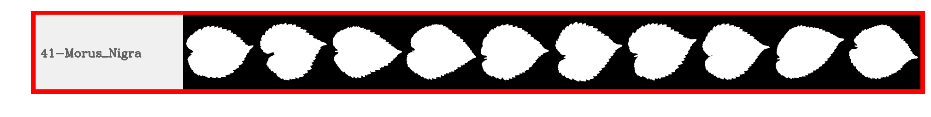

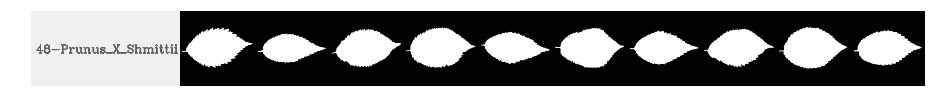

##################################################
Error index in the test set:  125
Ground truth species index: 29
Wrong predicting species index: 28


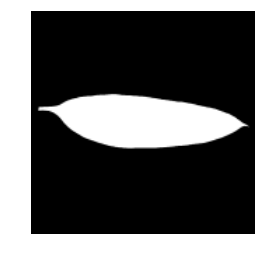

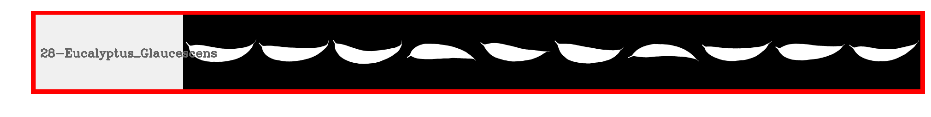

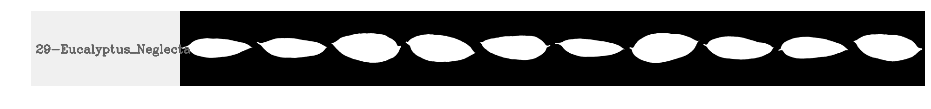

##################################################


In [29]:
visualize_error(train_predictions, y_test)

#### 4.2.4 K-Nearest Neighbours 

In [36]:
clf = KNeighborsClassifier(3)  # Instantiate a classifier
clf.fit(X_train, y_train) # Fit this classifier to the data
print 'ML Model: ', clf.__class__.__name__

# Cross-validation
scores = cross_val_score(KNeighborsClassifier(3), train.values, labels, cv=ss_split)
#print 'Mean Cross-validation scores: {}'.format(np.mean(scores))

train_predictions = clf.predict(X_test)
acc = accuracy_score(y_test, train_predictions)
print 'Accuracy: {:.4%}'.format(acc)

train_predictions = clf.predict_proba(X_test)
ll = log_loss(y_test, train_predictions)
print 'Log Loss: {:.6}'.format(ll)

ML Model:  KNeighborsClassifier
Accuracy: 87.8788%
Log Loss: 2.25021


#### 4.2.5 Linear Discriminant Analysis

In [43]:
clf = LinearDiscriminantAnalysis().fit(X_train, y_train)
print 'ML Model: ', clf.__class__.__name__

train_predictions = clf.predict(X_test)
acc = accuracy_score(y_test, train_predictions)
print 'Accuracy: {:.4%}'.format(acc)

train_predictions_p = clf.predict_proba(X_test)
ll = log_loss(y_test, train_predictions_p)
print 'Log Loss: {:.6}'.format(ll)

ML Model:  LinearDiscriminantAnalysis
Accuracy: 97.4747%
Log Loss: 0.922523


The error indices:  [ 17  24 138 141 197]
Error index in the test set:  17
Ground truth species index: 85
Wrong predicting species index: 3


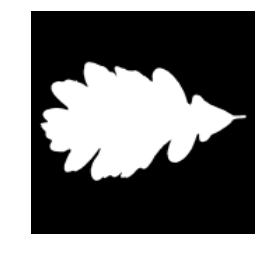

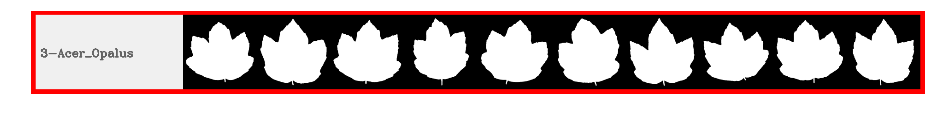

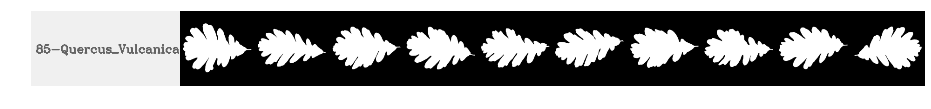

##################################################
Error index in the test set:  24
Ground truth species index: 48
Wrong predicting species index: 41


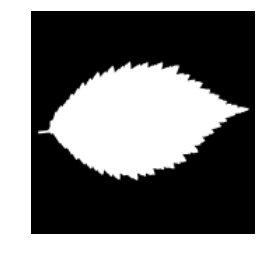

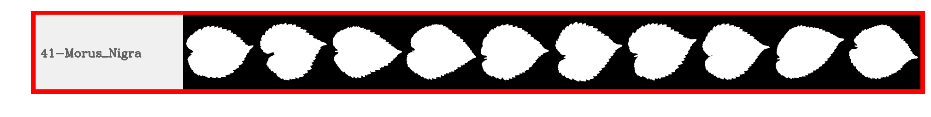

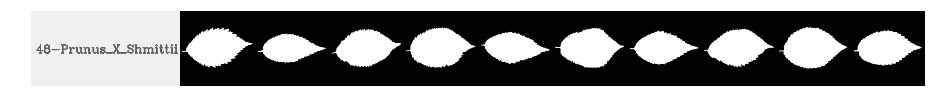

##################################################
Error index in the test set:  138
Ground truth species index: 63
Wrong predicting species index: 71


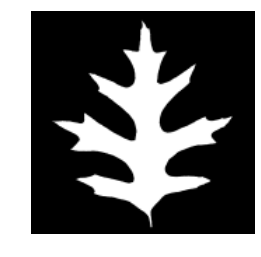

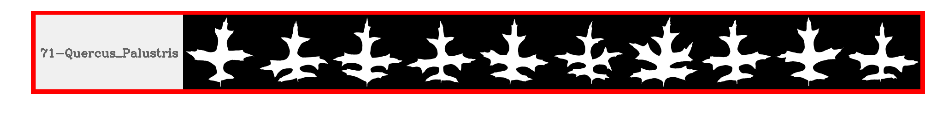

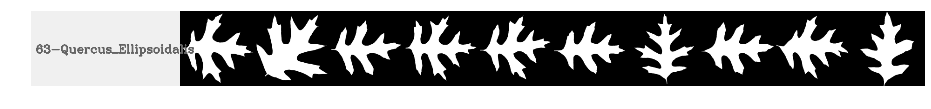

##################################################
Error index in the test set:  141
Ground truth species index: 46
Wrong predicting species index: 31


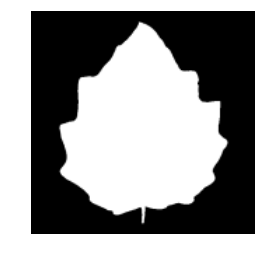

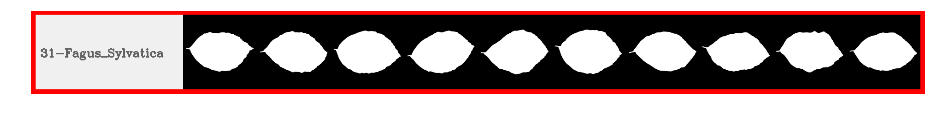

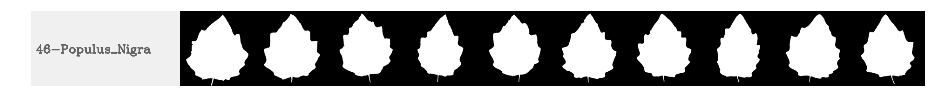

##################################################
Error index in the test set:  197
Ground truth species index: 15
Wrong predicting species index: 28


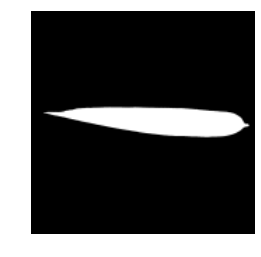

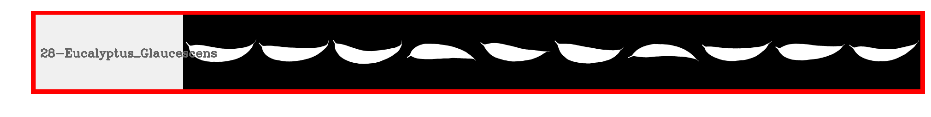

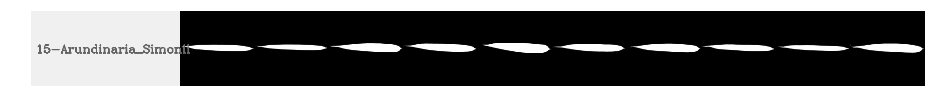

##################################################


In [52]:
visualize_error(train_predictions, y_test)

## 5. Postprocessing
This part is to format the output for **Kaggle**:

In [30]:
# Standardize the training data.
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# Using the optimal parameters
param_grid = {'C': [1000],
              'tol': [0.000001]}
log_reg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
grid_search = GridSearchCV(log_reg, param_grid, scoring='neg_log_loss', refit='True', n_jobs=1, cv=ss_split)
grid_search.fit(X_train_scaled, y_train)

scaler = StandardScaler().fit(test)
test_scaled = scaler.transform(test)

test_predictions = grid_search.predict_proba(test_scaled)

# Format DataFrame
submission = pd.DataFrame(test_predictions, columns=classes)
submission.insert(0, 'id', test_ids)
submission.reset_index()

# Export Submission
submission.to_csv('submission_1208.csv', index = False)

# Double check the output
submission.head()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,9.011771e-11,1.110714e-09,2.630495e-13,3.718941e-08,2.363799e-09,4.058135e-09,1.766116e-13,2.362772e-12,7.389599e-12,...,5.020218e-15,8.303768e-10,2.905493e-10,1.292005e-11,2.983515e-09,7.935317e-13,1.093279e-13,3.407816e-15,3.418609e-07,7.498299e-12
1,7,7.570072e-10,6.804737e-09,7.775672e-08,5.441809e-07,1.558225e-09,9.530481e-09,7.875757e-06,1.120013e-09,1.172679e-09,...,1.599578e-08,2.606640e-08,4.109826e-11,2.319869e-12,1.292137e-14,1.906140e-06,2.574039e-09,3.042343e-06,2.761686e-10,1.191397e-08
2,9,5.304015e-08,9.973254e-01,1.104012e-07,3.861722e-08,2.149882e-03,3.737330e-06,2.816412e-08,8.374068e-06,5.784697e-05,...,2.251034e-07,6.744143e-09,6.969635e-08,1.280773e-08,3.413016e-09,6.900657e-09,1.382368e-07,5.420523e-11,1.219872e-08,6.960756e-05
3,12,2.784955e-09,1.212906e-03,8.255841e-08,1.851703e-08,2.204091e-07,3.158771e-09,8.428335e-06,2.894022e-07,6.235449e-06,...,5.251295e-07,7.978805e-09,7.652138e-08,5.448008e-10,2.523963e-10,7.762151e-07,5.167917e-04,2.916363e-08,4.298067e-09,7.702478e-05
4,13,5.941649e-08,5.113692e-08,1.419719e-10,1.703098e-11,2.955049e-08,1.399018e-10,5.360808e-08,7.858605e-09,3.747991e-06,...,2.471360e-08,9.551247e-11,4.753565e-07,3.631222e-10,5.299508e-07,2.564942e-07,3.843323e-06,9.353378e-10,1.241538e-08,9.260274e-09


## 6. Results and Discussion

|ML Model|Accuracy|Log loss|
|--------|--------|--------|
|Gaussian NB|55.0505%|15.5066|
|SVM|93.4343%|2.30151|
|**Logistic Regression**|98.9899%|0.0469722|
|KNeighborsClassifier|87.8788%|2.25021|
|LinearDiscriminantAnalysis|97.4747%|0.922523|

The results of the five classifiers are listed in the above table. We can see that Gaussian Naive Bayes didn't perform well in this classification task. The other four classifiers all have relatively good performance. Logistic Regression and Linear Discriminant Analysis both have very high predicting accuracy, but Logistic Regression exhibited less Log loss. Then we can say Logistic Regression is the best classifier in classifying leaves.

### Kaggle Rank

After postprocessing, I sumbmited the above prediction to Kaggle and got the rank 194/874 (Top 23%) with the evaluated Log loss of 0.03157, which is not bad but still have a lot of space to be improved.

## 7. Conclusion and Future Work

In this project, machine learning methods including Naive Bayes, Support Vector Machine (SVM), Logistic Regression, k-nearest neighbours (k-NN) and Linear Discriminant Analysis are implemented and compared. Standard-scaler is applied to preprocess the data. Cross-validation is used to improve the generalization performance of the model. Grid-search is used in finding the optimal parameters. The best prediction accurary is from Logistic Regression, which has the accuracy of ~99%.
### Future Work

1. Keep optimizing the logistic regression classifier to improve its performance.
2. Try other machine learning model to takle this problem.
3. Develop a pipeline to classify leaf from its raw colorful image.

## References
[1] Andreas C. Müller and Sarah Guido, Introduction to Machine Learning with Python. [GitHub](https://github.com/amueller/introduction_to_ml_with_python)

[2] Mallah, Charles, James Cope, and James Orwell. "Plant leaf classification using probabilistic integration of shape, texture and margin features." Signal Processing, Pattern Recognition and Applications 5 (2013): 1.

[3] Mallah, CharlesD. "Probabilistic classification from a k-nearest-neighbour classifier." Computational Research 1.1 (2013): 1-9.

----------
## Instructions of running the code:
This report and code snippets are implemented in Jupyter Notebook.

Environment: Anaconda + Python 2.7

Dependent packages:
- numpy
- seaborn
- pandas
- matplotlib
- sklearn
- cv2